# Реализовать синтезирование лиц из LFW с помощью DCGAN.
 Библиотеки: [Python, Tensorflow]

## Переключение версии TensorFlow

In [1]:
%tensorflow_version 2.x

UsageError: Line magic function `%tensorflow_version` not found.


In [43]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
%matplotlib inline

## Загрузка и подготовка датасета LFW

In [3]:
train_ds, ds_info = tfds.load(
    'lfw',
    with_info=True,
    split='train'
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\Armik\tensorflow_datasets\lfw\0.1.0.incompleteM557O0\lfw-train.tfrecord*...:   0%|         …

Dataset lfw downloaded and prepared to C:\Users\Armik\tensorflow_datasets\lfw\0.1.0. Subsequent calls will reuse this data.


In [4]:
ds_info

tfds.core.DatasetInfo(
    name='lfw',
    full_name='lfw/0.1.0',
    description="""
    Labeled Faces in the Wild: A Database for Studying Face Recognition in
    Unconstrained Environments
    """,
    homepage='http://vis-www.cs.umass.edu/lfw',
    data_path='C:\\Users\\Armik\\tensorflow_datasets\\lfw\\0.1.0',
    file_format=tfrecord,
    download_size=172.20 MiB,
    dataset_size=180.28 MiB,
    features=FeaturesDict({
        'image': Image(shape=(250, 250, 3), dtype=uint8),
        'label': Text(shape=(), dtype=string),
    }),
    supervised_keys=('label', 'image'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=13233, num_shards=2>,
    },
    citation="""@TechReport{LFWTech,
        author = {Gary B. Huang and Manu Ramesh and Tamara Berg and Erik Learned-Miller},
        title = {Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments},
        institution = {University of Massachusetts, Amherst},


## Визуализация датасета LFW

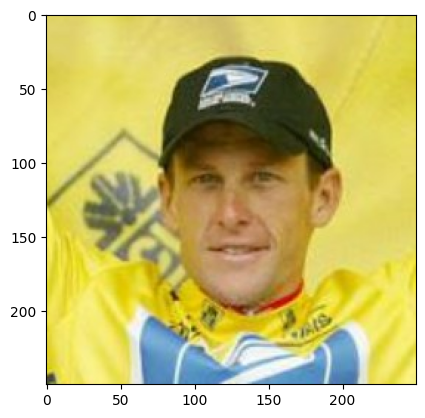

In [17]:
for example in train_ds.take(20):
    image = example['image']
    plt.imshow(image.numpy().astype(np.float32)/255) # showing one example

In [18]:
train_x = [tf.image.rgb_to_grayscale(x['image'].numpy().reshape(250, 250, 3)) for x in train_ds]

In [19]:
train_x[0].shape

TensorShape([250, 250, 1])

In [20]:
len(train_x)

13233

## Deep Convolutional GAN (DCGAN)

In [21]:
generator = tf.keras.Sequential([
    tf.keras.layers.Dense(128*7*7, activation='relu'),
    tf.keras.layers.Reshape((7, 7, 128)),
    tf.keras.layers.UpSampling2D((2, 2)),    
    tf.keras.layers.Conv2D(128, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(),    
    tf.keras.layers.UpSampling2D((2, 2)),    
    tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(),    
    tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation='tanh'),
])

discriminator = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same'),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.Dropout(0.25),    
    tf.keras.layers.Conv2D(64, kernel_size=3, strides=(2, 2), padding='same'),
    tf.keras.layers.ZeroPadding2D(padding=((0, 1), (0, 1))),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, kernel_size=3, strides=(2, 2), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(256, kernel_size=3, strides=(1, 1), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1),
])

##Подготовка датасета

In [22]:
def prepare(img):
    img = tf.cast(img, tf.float32) / 255.
    return tf.image.resize(img, (28, 28))

In [33]:
INPUT_DIM = 100
NUM_EPOCHS = 50
HALF_BATCH_SIZE = 16
BATCH_SIZE = HALF_BATCH_SIZE * 2
LEARNING_RATE = 0.0002

train_ds = tf.data.Dataset.from_tensor_slices(train_x)
train_ds = train_ds.shuffle(buffer_size=len(train_x))
train_ds = train_ds.map(prepare)
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(HALF_BATCH_SIZE, drop_remainder=True)

optimizer = tf.keras.optimizers.legacy.Adam(LEARNING_RATE)
sigmoid_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [34]:
train_ds

<_BatchDataset element_spec=TensorSpec(shape=(16, 28, 28, 1), dtype=tf.float32, name=None)>

In [44]:
def plot_pics(samples):
    fig = plt.figure(figsize=(20, 20))
    num = samples.shape[0]
    for j in range(num):
        ax = fig.add_subplot(6, 8, j+1)
        ax.imshow(samples[j, ...].reshape(28, 28), cmap='gray')
        plt.xticks([]), plt.yticks([])
    plt.show()

1/1 [==============================] - 0s 71ms/step
[Step  0] D Loss: 0.2259; G Loss: 0.7859
1/1 [==============================] - 0s 51ms/step


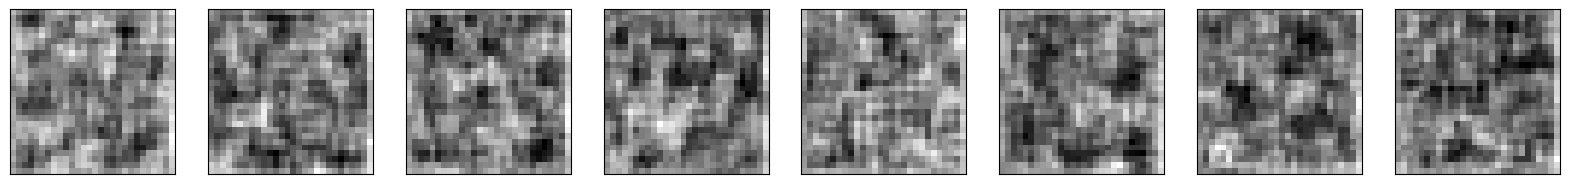

1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 0s 60ms/step


1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 60ms/step
[Step 500] D Loss: 0.0001; G Loss: 0.2977
1/1 [==============================] - 0s 49ms/step


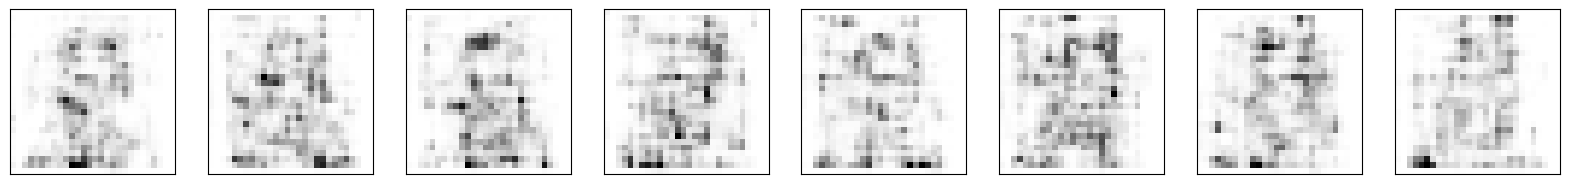

1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 0s 60ms/step
[Step 1000] D Loss: 0.0003; G Loss: 0.0155
1/1 [==============================] - 0s 50ms/step


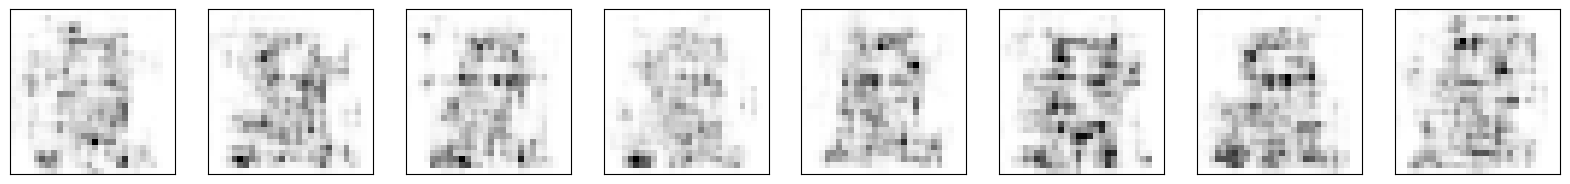

1/1 [==============================] - 0s 60ms/step


1/1 [==============================] - 0s 60ms/step


1/1 [==============================] - 0s 60ms/step


1/1 [==============================] - 0s 61ms/step
[Step 1500] D Loss: 0.0002; G Loss: 0.0042
1/1 [==============================] - 0s 51ms/step


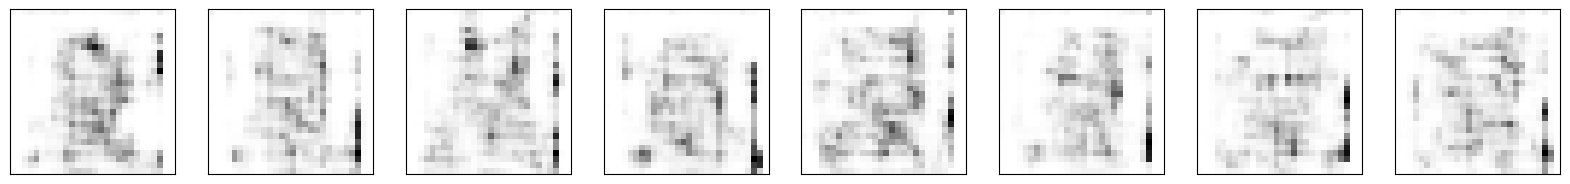

1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 61ms/step


1/1 [==============================] - 0s 64ms/step


1/1 [==============================] - 0s 65ms/step
[Step 2000] D Loss: 0.0014; G Loss: 0.0132
1/1 [==============================] - 0s 54ms/step


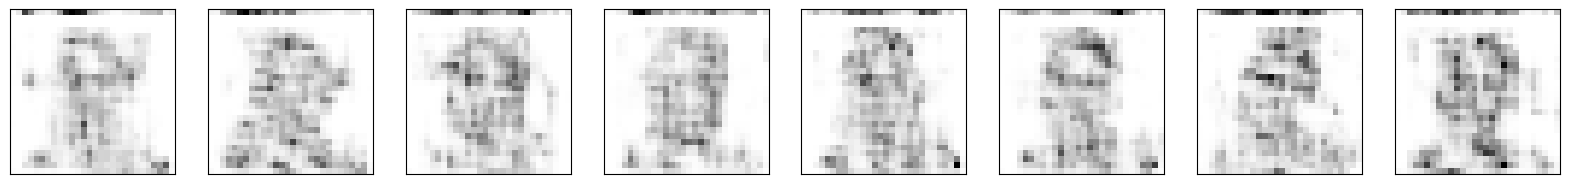

1/1 [==============================] - 0s 64ms/step


1/1 [==============================] - 0s 68ms/step


1/1 [==============================] - 0s 67ms/step


1/1 [==============================] - 0s 64ms/step
[Step 2500] D Loss: 0.0000; G Loss: 0.1310
1/1 [==============================] - 0s 55ms/step


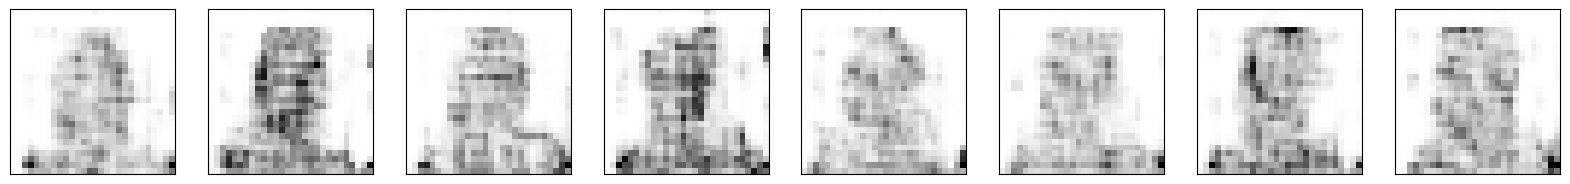

1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 71ms/step


1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 69ms/step
[Step 3000] D Loss: 0.0001; G Loss: 0.0075
1/1 [==============================] - 0s 56ms/step


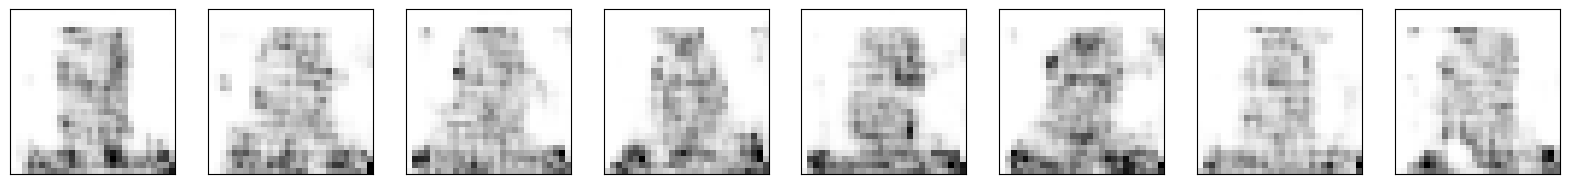

1/1 [==============================] - 0s 64ms/step


1/1 [==============================] - 0s 70ms/step


1/1 [==============================] - 0s 68ms/step


1/1 [==============================] - 0s 67ms/step
[Step 3500] D Loss: 0.0000; G Loss: 0.0366
1/1 [==============================] - 0s 57ms/step


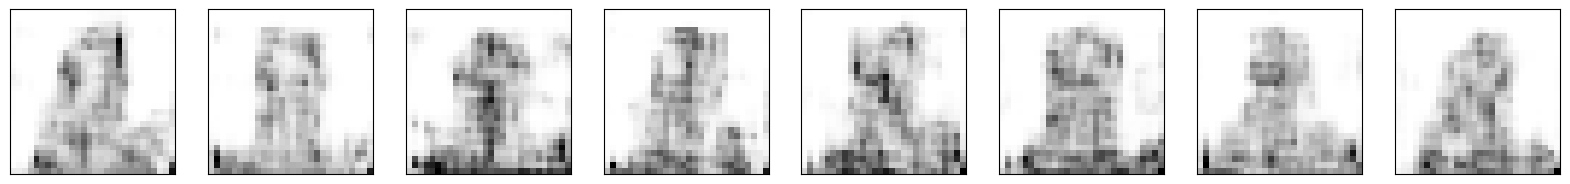

1/1 [==============================] - 0s 69ms/step


1/1 [==============================] - 0s 72ms/step


1/1 [==============================] - 0s 76ms/step


1/1 [==============================] - 0s 71ms/step
[Step 4000] D Loss: 0.0000; G Loss: 0.1410
1/1 [==============================] - 0s 58ms/step


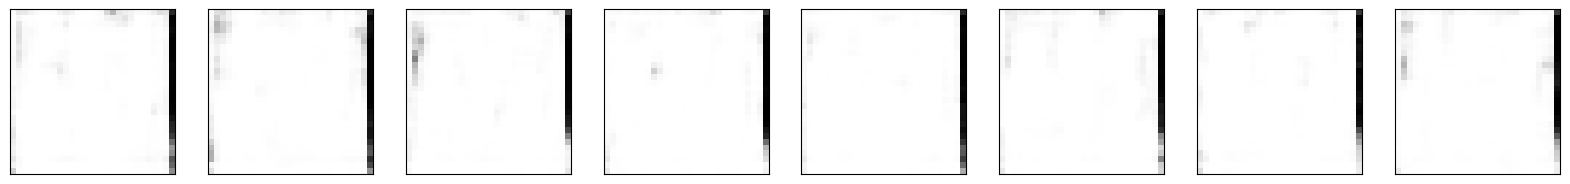

1/1 [==============================] - 0s 70ms/step


1/1 [==============================] - 0s 73ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 78ms/step
[Step 4500] D Loss: 0.0001; G Loss: 0.0032
1/1 [==============================] - 0s 64ms/step


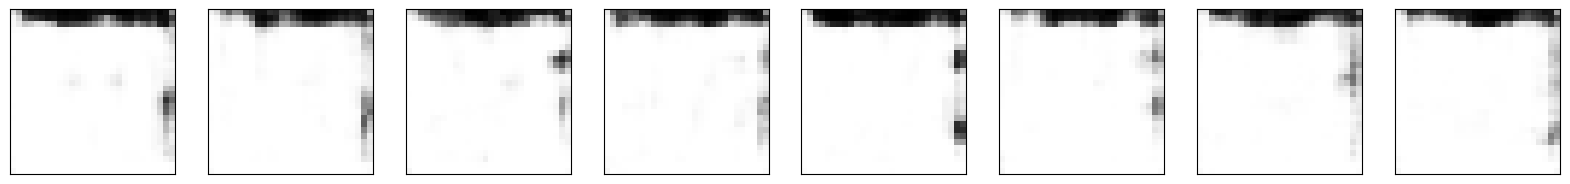

1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 75ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 77ms/step
[Step 5000] D Loss: 0.0000; G Loss: 0.0974
1/1 [==============================] - 0s 64ms/step


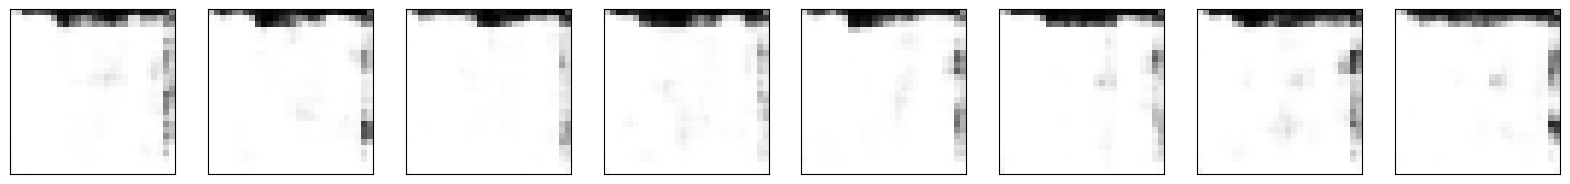

1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 78ms/step
[Step 5500] D Loss: 0.0000; G Loss: 0.0160
1/1 [==============================] - 0s 71ms/step


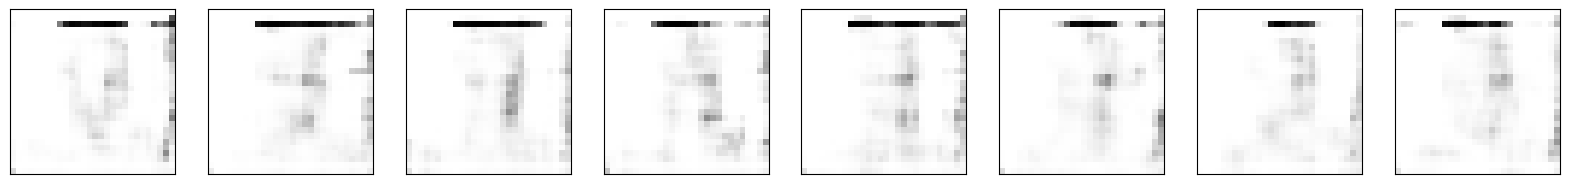

1/1 [==============================] - 0s 91ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 84ms/step
[Step 6000] D Loss: 0.0001; G Loss: 0.2181
1/1 [==============================] - 0s 73ms/step


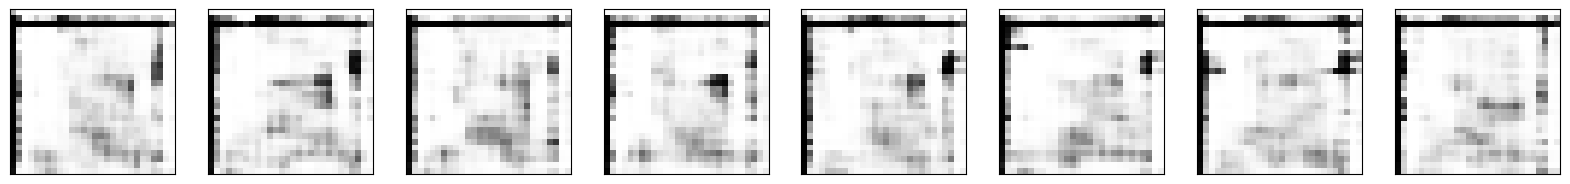

1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 87ms/step


1/1 [==============================] - 0s 87ms/step
[Step 6500] D Loss: 0.0001; G Loss: 0.2948
1/1 [==============================] - 0s 76ms/step


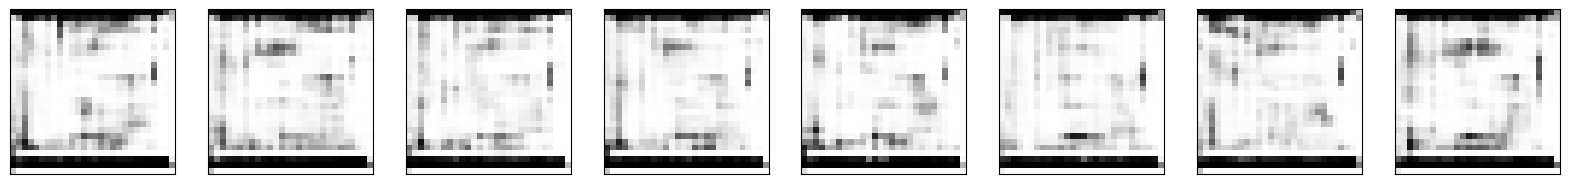

1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 93ms/step


1/1 [==============================] - 0s 92ms/step


1/1 [==============================] - 0s 91ms/step
[Step 7000] D Loss: 0.0000; G Loss: 0.6389
1/1 [==============================] - 0s 78ms/step


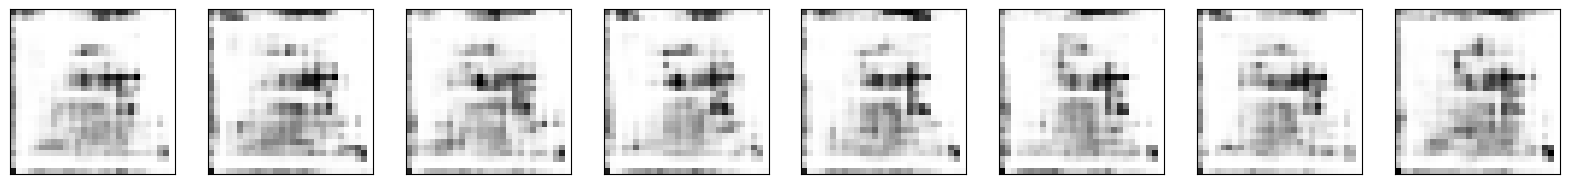

1/1 [==============================] - 0s 93ms/step


In [37]:
for step, true_images in enumerate(train_ds):
    
    # Train Discriminator
    
    noise = np.random.normal(0, 1, (HALF_BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    syntetic_images = generator.predict(noise)
    x_combined = np.concatenate((
        true_images, 
        syntetic_images))
    y_combined = np.concatenate((
        np.ones((HALF_BATCH_SIZE, 1), np.float32), 
        np.zeros((HALF_BATCH_SIZE, 1), np.float32)))
    
    with tf.GradientTape() as tape:
        # For small numbers of inputs that fit in one batch <= model.predict()
        logits = discriminator(x_combined, training=True) 
        d_loss_value = sigmoid_cross_entropy(y_combined, logits)
        # discriminator.trainable_variables
    grads = tape.gradient(d_loss_value, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))
    
    # Train Generator
    
    noise = np.random.normal(0, 1, (BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    y_mislabled = np.ones((BATCH_SIZE, 1), np.float32)
    
    with tf.GradientTape() as tape:
        syntetic = generator(noise, training=True)
        logits = discriminator(syntetic, training=True)
        g_loss_value = sigmoid_cross_entropy(y_mislabled, logits)
    grads = tape.gradient(g_loss_value, generator.trainable_variables)
    optimizer.apply_gradients(zip(grads, generator.trainable_variables))
    
    # Check intermediate results
    
    if step % 500 == 0:
        print('[Step %2d] D Loss: %.4f; G Loss: %.4f' % (
            step, d_loss_value.numpy(), g_loss_value.numpy()))
        noise = np.random.normal(0, 1, (8, INPUT_DIM)).astype(np.float32)
        syntetic_images = generator.predict(noise)
        plot_pics(syntetic_images)


## Тестирование свёрточного генератора

In [45]:
noise = np.random.normal(0, 1, (32, INPUT_DIM)).astype(np.float32)
syntetic_images = generator.predict(noise)
plot_pics(syntetic_images)

## Интерполяция в латентном пространстве

In [46]:
noise_1 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise_2 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise = np.linspace(noise_1, noise_2, 8)
syntetic_images = generator.predict(noise)
plot_pics(syntetic_images)